In [ ]:
from timeit import default_timer
start = default_timer()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Dowload dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


--2021-11-08 18:06:21--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  10.8MB/s    in 18s     

2021-11-08 18:06:39 (10.7 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  /content/ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/ml-20m

/content/ml-20m


In [ ]:
!ls

genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


# EDA

## Load Data

In [ ]:
tag = pd.read_csv("tags.csv")
movies = pd.read_csv("movies.csv")
rating = pd.read_csv("rating.csv")
link = pd.read_csv("links.csv")
genome_tags = pd.read_csv("genome-tags.csv")
genome_scores = pd.read_csv("genome-scores.csv")

In [ ]:
rating_movies = rating[["rating","timestamp"]]

In [ ]:
from timeit import default_timer

st = default_timer()

# First time data load.
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('rating.csv')
    
# Organise a bit and store into feather-format
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)
    
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId         int64
movieId        int64
rating       float64
timestamp     object
dtype: object
Number of movies Null values:  22
Number of ratings Null values:  0
Elapsed time(sec):  49.66


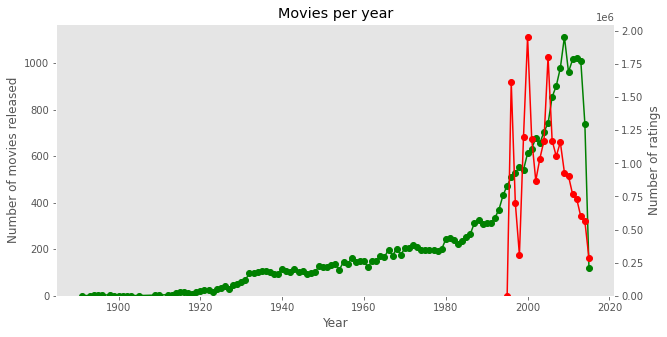

Elapsed time(sec):  0.83


In [ ]:

st = default_timer()

# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

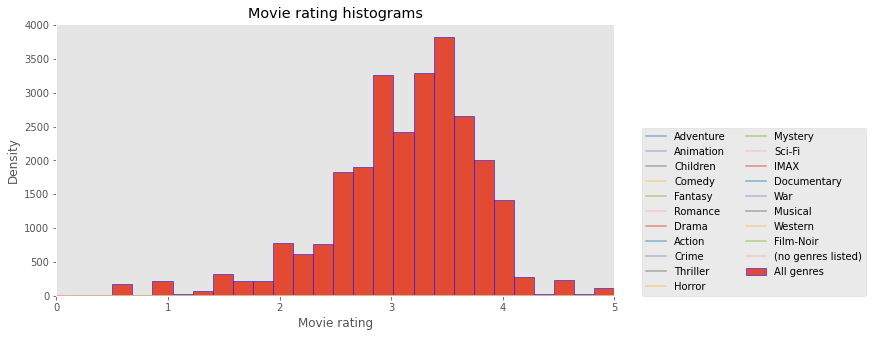

Elapsed time(sec):  36.81


In [ ]:
st = default_timer()

dftmp = ratings[['movieId','rating']].groupby('movieId').mean()

# Initialize empty list to capture basic stats by genre
rating_stats = []
# Plot general histogram of all ratings
dftmp.hist(bins=25, grid=False, edgecolor='b', label ='All genres', figsize=(10,5))
# Plot histograms (kde lines for better visibility) per genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]==True]
    dftmp = ratings[ratings.set_index('movieId').index.isin(dftmp.set_index('movieId').index)]
    dftmp = dftmp[['movieId','rating']].groupby('movieId').mean()
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    avg = dftmp.rating.mean()
    std = dftmp.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

# Housekeeping
%reset_selective -f (^avg$|^dftmp$|^genre$|^std$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<Figure size 720x360 with 0 Axes>

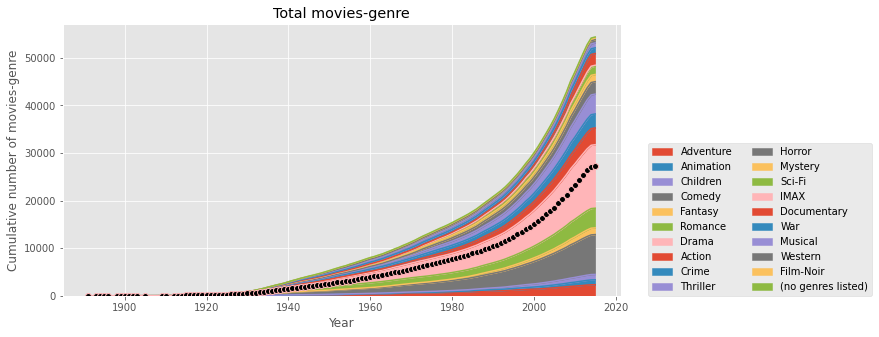

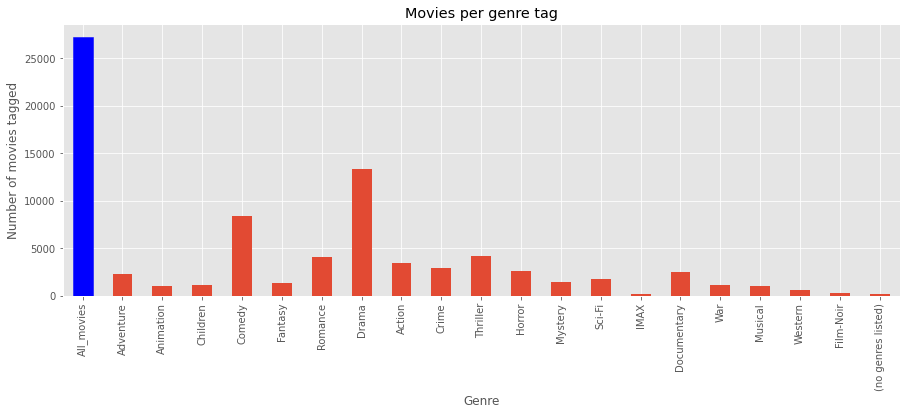

Elapsed time(sec):  0.79


In [ ]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

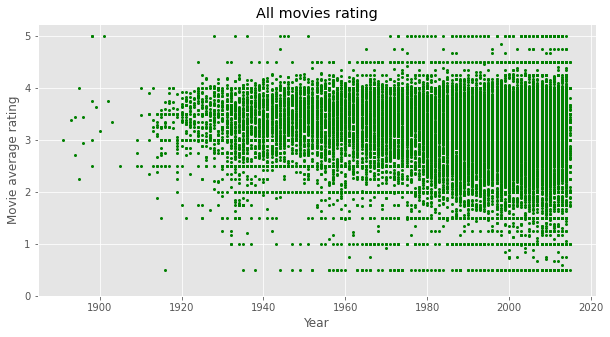

Elapsed time(sec):  1.3


In [ ]:
st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

# Lọc và tạo dữ liệu huấn luyện

## Lọc dữ liệu

In [ ]:
original_ratings = pd.read_csv('ratings.csv')

In [ ]:
genome_scores = pd.read_csv('genome-scores.csv')

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675
...,...,...,...
11709763,131170,1124,0.58775
11709764,131170,1125,0.01075
11709765,131170,1126,0.01575
11709766,131170,1127,0.11450


In [ ]:
# Lấy danh sách phim có genome
movieId_has_genome = genome_scores.movieId.value_counts().index.values

In [ ]:
# Lọc danh sách các bộ phim có >=20 lượt rating
movieId_has_20ratings = original_ratings.movieId.value_counts().loc[original_ratings.movieId.value_counts()>=20].index.values
filtered_ratings_1 = original_ratings.loc[original_ratings.movieId.isin(movieId_has_20ratings)]

In [ ]:
# Lọc danh sách các user có >=20 lượt rating
userId_has_20ratings = filtered_ratings_1.userId.value_counts().loc[filtered_ratings_1.userId.value_counts()>=20].index.values
filtered_ratings_2 = filtered_ratings_1.loc[filtered_ratings_1.userId.isin(userId_has_20ratings)]

In [ ]:
# Sau khi lọc xong, một số movie cũng như user bị xóa, do đó cần thực hiện lại bước 1
# Lấy danh sách phim có genome
filtered_ratings3 = filtered_ratings_2.loc[filtered_ratings_2.movieId.isin(movieId_has_genome)].reset_index(drop=True)

In [ ]:
userId_has_20ratings = filtered_ratings3.userId.value_counts().loc[filtered_ratings3.userId.value_counts()>=20].index.values
filtered_ratings = filtered_ratings3.loc[filtered_ratings3.userId.isin(userId_has_20ratings)]

In [ ]:
# Lưu laị danh dữ liệu đã lọc
list_movie = filtered_ratings.movieId.value_counts().index.values
genome_scores_filtered = genome_scores.loc[genome_scores.movieId.isin(list_movie)]
genome_scores_filtered.to_csv('genome_scores_filtered.csv')
filtered_ratings.to_csv('filtered_ratings.csv', index=False)

## Chia dữ liệu training, validation, testing với tỉ lệ 70%-20%-10%

In [ ]:
# Load dữ liệu
ratings = pd.read_csv('filtered_ratings.csv')

In [ ]:
# Chia dữ liệu training, với mỗi user lấy ngẫu nhiên 70% movie
training_set_tmp = ratings.groupby(ratings.userId)[['movieId', 'rating','timestamp']].apply(lambda x: x.sample(frac=0.7, random_state = 10)).reset_index()
training_set_70 = training_set_tmp.drop(labels='level_1', axis=1)

In [ ]:
# Chia dữ liệu testing theo user từ 30% còn lại
testing_set_tmp = pd.merge(ratings,training_set_70, on= ['movieId', 'rating','timestamp'],how="outer",indicator=True)
testing_set_tmp = testing_set_tmp[testing_set_tmp['_merge']=='left_only']
testing_set_tmp = testing_set_tmp.drop(labels=['userId_y','_merge'], axis=1).rename(columns={'userId_x':'userId'})
test_set_10 = testing_set_tmp.groupby(testing_set_tmp.userId)[['movieId', 'rating','timestamp']].apply(lambda x: x.sample(frac=0.333, random_state = 13)).reset_index().drop(labels='level_1', axis=1)

In [ ]:
# Chia dữ liệu validation
valid_set_20 = pd.merge(testing_set_tmp,test_set_10, on= ['movieId', 'rating','timestamp'],how="outer",indicator=True)
valid_set_20 = valid_set_20[valid_set_20['_merge']=='left_only']
valid_set_20 = valid_set_20.drop(labels=['userId_y','_merge'], axis=1).rename(columns={'userId_x':'userId'})

In [ ]:
# Lưu lại các tập dữ liệu
training_set_70 = training_set_70.sort_values(by=['userId', 'movieId']).reset_index(drop=True)
test_set_10 = test_set_10.sort_values(by=['userId', 'movieId']).reset_index(drop=True)
valid_set_20 = valid_set_20.sort_values(by=['userId', 'movieId']).reset_index(drop=True)
training_set_70.to_csv('training_set_70.csv', index=False)
test_set_10.to_csv('testing_set_10.csv', index=False)
valid_set_20.to_csv('valid_set_20.csv', index=False)

## Tạo user genome

In [ ]:
# Load dữ liệu
data = pd.read_csv("training_set_70.csv")

In [ ]:
# Chuẩn hóa dữ liệu theo maxminscale
max_value = data['rating'].max()
min_value = data['rating'].min()
data['rating'] = (data['rating'] - min_value) / (max_value - min_value)

In [ ]:
# Hàm reset index theo userid
def reset_idx(df):
    df_new = df.copy()
    user = df.userId.unique().tolist()
    movie = df.sort_values(by='movieId').movieId.unique().tolist()
    user_dict = dict(zip(user, list(range(len(user)))))
    movie_dict = dict(zip(movie, list(range(len(movie)))))
    df_new['userId'] = df_new['userId'].map(user_dict)
    df_new['movieId'] = df_new['movieId'].map(movie_dict)
    return df_new
# hàm tạo user genome cho 1 user Id
def creat_user_features(genome,data,i):  
    total_feature = 0
    count = 0
    user = data[data.userId == i]
    user = user.values
    for row in user:
        total_feature += genome[int(row[1])]*row[2]
        count += 1
        
    return np.divide(total_feature,count)

In [ ]:
# Tạo user genome cho toàn bộ user
data = reset_idx(data)
user_genome = np.zeros((138185,1128), dtype = 'float')
for i in range(138185):
    user_feature = creat_user_features(genome,data,i)
    user_genome[i,:] = user_feature
user_genome = np.around(user_genome,5)

In [ ]:
# Lưu dữ liệu lại dưới dạng npy
np.save('user_genome.npy', user_genome)